Significant effort in solving machine learning problems goes into data preparation. PyTorch provides many tools to make data loading easy and more readable. In this tutorial, we will see how to load and preprocess data from a simple dataset.

For this tutorial, please make sure the `matplotlib` package is installed for easier visualization.

In [1]:
import torch
import torchaudio
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Opening a dataset

Torch audio supports loading sound files in the wav and mp3 format with 
`tensor, frequency = torchaudio.load(filename)`. 
It also supports importing the VCTK and YESNO dataset [out of the box](https://pytorch.org/audio/datasets.html). For instance the VCTK dataset can be loaded like so.

In [2]:
dataset = torchaudio.datasets.VCTK("~/VCTK", download=True)

Let's see how many samples there are in this dataset, but let's focus on the first audio signal.

In [3]:
dataset.num_samples

44257

In [4]:
ith_sample = 0
tensor = dataset[ith_sample][0]

tensor.size()

torch.Size([1, 235536])

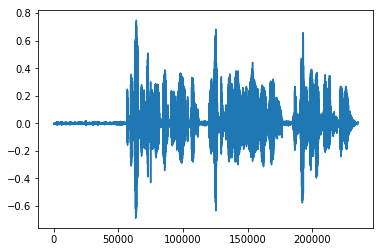

In [5]:
p = plt.plot(tensor.transpose(0,1).numpy())

# Migrating to Torch Audio from Kaldi

Users may be familiar with [Kaldi](http://github.com/kaldi-asr/kaldi), a toolkit for speech recognition. Torch Audio offers compatibility with it in `torchaudio.kaldi_io`. It can indeed read from kaldi scp, or ark file or streams with:

* read_vec_int_ark
* read_vec_flt_scp
* read_vec_flt_arkfile/stream
* read_mat_scp
* read_mat_ark

# Transformations

Torch audio supports a growing list of [transformations](https://pytorch.org/audio/transforms.html). 

* **Scale**: Scale audio tensor from a 16-bit integer (represented as a FloatTensor) to a floating point number between -1.0 and 1.0.  Note the 16-bit number is called the "bit depth" or "precision", not to be confused with "bit rate".
* **PadTrim**: PadTrim a 2d-Tensor
* **Downmix**: Downmix any stereo signals to mono.
* **LC2CL**: Permute a 2d tensor from samples (n x c) to (c x n).
* **Resample**: Resample the signal to a different frequency.
* **Spectrogram**: Create a spectrogram from a raw audio signal
* **MelScale**: This turns a normal STFT into a mel frequency STFT, using a conversion matrix.  This uses triangular filter banks.
* **SpectrogramToDB**: This turns a spectrogram from the power/amplitude scale to the decibel scale.
* **MFCC**: Create the Mel-frequency cepstrum coefficients from an audio signal
* **MelSpectrogram**: Create MEL Spectrograms from a raw audio signal using the STFT function in PyTorch.
* **BLC2CBL**: Permute a 3d tensor from Bands x Sample length x Channels to Channels x Bands x Samples length.
* **MuLawEncoding**: Encode signal based on mu-law companding. 
* **MuLawExpanding**: Decode mu-law encoded signal.

Since all transforms are nn.Modules or jit.ScriptModules, they can be used as part of a neural network at any point.

To start, we can look at the log of the spectrogram on a log scale.

torch.Size([1, 1178, 201])


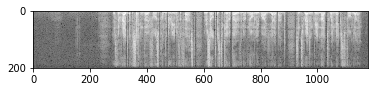

In [6]:
spec = torchaudio.transforms.Spectrogram()(tensor)
print(spec.size())
p = plt.imshow(spec.log2().transpose(1,2)[0,:,:].numpy(), cmap='gray')

Or we can look at the Mel Spectrogram on a log scale.

torch.Size([1, 1178, 128])


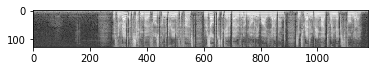

In [7]:
mel = torchaudio.transforms.MelSpectrogram()(tensor)
print(mel.size())
p = plt.imshow(mel.log2().transpose(1,2)[0,:,:].detach().numpy(), cmap='gray')

We can resample the signal.

In [17]:
# Original frequency of the signal
# NOTE It can be obtained when loading data: tensor, frequency = torchaudio.load(filename)
original_frequency = 48000
new_frequency = original_frequency/48
resampled = torchaudio.transforms.Resample(original_frequency, new_frequency)(tensor)
resampled.size()

torch.Size([1, 4907])

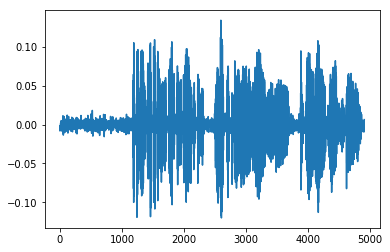

In [18]:
p = plt.plot(resampled[0,:].numpy())

We can also compose transformations. For instance, we can reduce the signal from stereo to mono and revisit the spectrogram. However, the signal was already mono since the size of the tensor was 1 x n. :-)

In [8]:
spec = composed = torchaudio.transforms.Compose([
    torchaudio.transforms.LC2CL(),
    torchaudio.transforms.DownmixMono(),
    torchaudio.transforms.LC2CL(),
    torchaudio.transforms.Spectrogram(),
])(tensor)
print(spec.size())

torch.Size([1, 1178, 201])


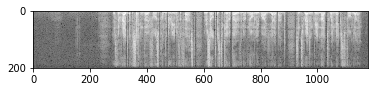

In [9]:
p = plt.imshow(spec.log2().transpose(1,2)[0,:,:].numpy(), cmap='gray')

As another example of transformations, we can encode the signal based on the Mu-Law companding. But to do so, we need the signal to be between -1 and 1. Since the tensor is just a regular PyTorch tensor, we can apply standard operators on it.

In [10]:
# Let's check if the tensor is in the interval [-1,1]
tensor.min(), tensor.max(), tensor.mean()

(tensor(-0.6873), tensor(0.7480), tensor(-4.2871e-06))

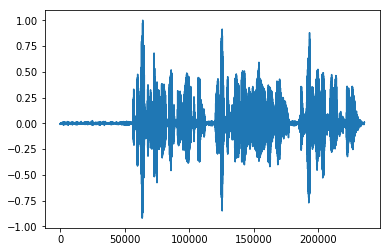

In [11]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

normalized = normalize(tensor)  # Let's normalize to the full interval [-1,1]

p = plt.plot(normalized[0,:].numpy())

In [12]:
transformed = torchaudio.transforms.MuLawEncoding()(normalized)
transformed.size()

torch.Size([1, 235536])

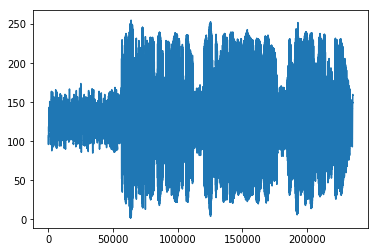

In [13]:
p = plt.plot(transformed[0,:].numpy())

In [14]:
recovered = torchaudio.transforms.MuLawExpanding()(transformed)
recovered.size()

torch.Size([1, 235536])

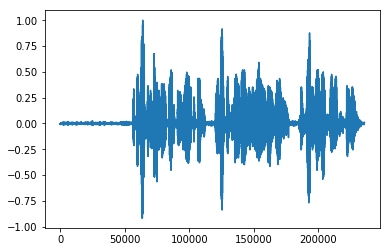

In [15]:
p = plt.plot(recovered[0,:].numpy())

In [16]:
recovered = torchaudio.transforms.MuLawExpanding()(transformed)

def compute_median_relative_difference(normalized, recovered):
    diff = (normalized-recovered)
    return (diff.abs()/normalized.abs()).median()

err = compute_median_relative_difference(normalized, recovered)
print("Median relative difference is {:.2%} between the original and MuLaw reconstucted signals".format(err))

Median relative difference is 1.49% between the original and MuLaw reconstucted signals


# Conclusion

We have used the VCTK dataset to illustrate how to open a dataset or other data using Torch Audio, and how to pre-process and transform an audio signal. Given that Torch Audio is built on PyTorch, these techniques can be used as building blocks for more advanced audio applications, such as speech recognition.